In [ ]:
# import packages
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import Bio
import statsmodels.api as sm


Import datasets and define variables

In [ ]:
# import data from computer
path: str = './data/' #folder where files are stored
species: pd.DataFrame = pd.read_csv(os.path.join(path, "cross-species.csv"), dtype=str)   # imports file from the folder as species, based on name
identifiers: pd.DataFrame = pd.read_csv(os.path.join(path, "identifiers.tsv"), sep='\t', dtype=str) # imports 3rd file from the folder, based on name

#import fasta file with biopython (Bio)
from Bio import SeqIO
fasta_id = []
fasta_seq = []
with open(os.path.join(path, "identifiers.fasta"), 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"): 
        fasta_id.append(record.id) 
        fasta_seq.append(str(record.seq))
# Create df prot_seq which includes proper ID and sequences
fasta_id_df = pd.DataFrame([item.split('|') for item in fasta_id], columns=['0', 'From','ID']) # creates a df by splitting fasta_id list into 3 columns
fasta_id_EntryName:list = fasta_id_df['ID'] # creates a list with the Entry Names from the split df
prot_seq = pd.DataFrame(list(zip(fasta_id_EntryName, fasta_seq)), columns = ["ID", "Sequence"]) # creates a df by combining the Entry Names and the Sequences



#Define datatype for each column
species['fold_change'] = species['fold_change'].astype('float64') # changes fold_change column to float64
species['temperature'] = species['temperature'].astype('float64') # changes temperature column to int64
identifiers['Length'] = identifiers['Length'].astype('float64') # changes Length column to int64

#Update index
species = species.reset_index(drop=True) # resets index of species df
identifiers = identifiers.reset_index(drop=True) # resets index of identifiers df




Add protein sequence from protein_seq dataset to identifiers to create identifiers_seq, based on 'ID' and 'Entry Name' respectively

Create joint data set from identifiers_seq and species_seq based on gene_name and Gene Names1 respectively

In [ ]:
# merge dataframes based on Entry Name (df.identifiers) andID (df.prot_seq), if they are similar add the sequence to identifiers, if not add NaN
identifiers_seq = identifiers.merge(prot_seq, how='left', left_on='Entry Name', right_on='ID')[identifiers.columns.tolist() + ['Sequence']] # merges identifiers and prot_seq on Entry Name and ID
identifiers_seq.head()

#merge species and identifiers_seq based on gene_name and Gene Names1
identifiers_seq[['Gene Names1', 'Gene Names2']] = identifiers_seq['Gene Names'].str.split(expand = True, n=1) # splits the Gene Names column into 2 columns
species_seq = pd.merge(left = species, right = identifiers_seq, how='outer', left_on='gene_name', right_on='Gene Names1') # merges species and identifiers_seq on gene_name and Gene Names1
#species_seq.head()

Drop all entries from species dataset which don't have a sequence.
Delete unnessesary columns ('Gene Names1', 'Gene Names2')

In [ ]:
species_seq.dropna(subset = ['Sequence'], inplace=True) # drops rows with NaN in the Sequence column

for col in ['Gene Names1', 'Gene Names2']:
    if col in species_seq.columns:
        species_seq.drop(columns = ['Gene Names1', 'Gene Names2'], inplace=True) # drops Gene Names1 and Gene Names2 columns
#species_seq.head()


Extract list of unique run_names from species and manually seperate in prokaryotes and eukaryotes. Create split datasets for eukaryotes and prokaryotes based on species_seq

In [ ]:
# Get a list of unique entries in the 'run_name' column
#print(species['run_name'].unique())

# Based on uniqe run names all entries split into eukaryotes and prokaryotes (manually)
prokaryotes_list:list = ['Bacillus subtilis_168_lysate_R1', 'Escherichia coli lysate',
 'Geobacillus stearothermophilus NCA26 lysate',
 'Thermus thermophilus HB27 lysate', 'Thermus thermophilus HB27 cells',
 'Escherichia coli cells', 'Picrophilus torridus DSM9790 lysate']

#creates new dataframes that only contain prokaryotes or eukaryotes based
prokaryotes_all = species_seq[species_seq['run_name'].isin(prokaryotes_list)]

##reset index
prokaryotes_all = prokaryotes_all.reset_index(drop=True) # resets index of species df

Create a list of each unique protein for each organism

In [ ]:
# prokaryotes
prokaryotes = prokaryotes_all.drop_duplicates(subset=['run_name', 'Protein_ID'], keep='first') #create new dataframe with only unique proteins
prokaryotes = prokaryotes.reset_index(drop=True) #reset index

# define meltpoint as float64
prokaryotes['meltPoint'] = prokaryotes['meltPoint'].astype('float64') # changes meltpoint column to float64
prokaryotes['temperature'] = prokaryotes['temperature'].astype('float64')

Calculate relative abundance of hydrophobic aminoacids for each protein and append to dataframe

In [21]:
from function import rel_aa_comp
from Aminoacid_lists import AA_hydrophobic, AA_polar_neutral, AA_acidic, AA_basic
prokaryotes['hydrophobic'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, AA_hydrophobic)) # calculates relative amino acid composition of hydrophobic amino acids
prokaryotes['polar_neutral'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, AA_polar_neutral)) # calculates relative amino acid composition of polar neutral amino acids
prokaryotes['acidic'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, AA_acidic)) # calculates relative amino acid composition of acidic amino acids
prokaryotes['basic'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, AA_basic)) # calculates relative amino acid composition of basic amino acids


Group dataframes based on run name

In [ ]:
prokaryotes_all_group = prokaryotes_all.groupby('run_name')
prokaryotes_group = prokaryotes.groupby('run_name')




Some plots to test data

In [ ]:
sns.scatterplot(data = prokaryotes, x = 'meltPoint', y = 'hydrophobic', label = 'hydrophobic', s= 10, alpha = 0.6)
sns.scatterplot(data=prokaryotes, x='meltPoint', y='polar_neutral', label = 'polar neutral', s= 10, alpha = 0.6)
sns.scatterplot(data= prokaryotes, x='meltPoint', y='acidic', label = 'acidic', s= 10, alpha = 0.6)
sns.scatterplot(data=prokaryotes, x='meltPoint', y='basic', label = 'basic', s= 10, alpha = 0.6)
plt.xticks(np.arange(30, 100, 5))
plt.ylabel('relative abundance of aminoacid properties')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



Calculate average hydrophic content for each organism and plot vs living temperature of organism

In [ ]:
prokaryotes_average = prokaryotes_group.mean(['temperature', 'hydrophobic', 'acidic', 'polar_neutral', 'basic'])
prokaryotes_average = prokaryotes_average.reset_index()

#plot hydrophobic agaisnt temp
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y = 'hydrophobic', hue = 'run_name', s= 50, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#Plot polar_neutral against temp
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y ='polar_neutral', hue = 'run_name', s= 50, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#Plot acidic against temp
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y ='polar_neutral', hue = 'run_name', s= 80, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#Plot basic against temp
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y ='polar_neutral', hue = 'run_name', s= 80, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Test for lysine and aspartic acid as indicator for stable and unstable proteins, respectively

In [ ]:
prokaryotes['Asp'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, ['D'])) # calculates relative Asp abundance
prokaryotes['Lys'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x, ['K'])) # calculates relative Glu abundance

#plot individual proteins
sns.scatterplot(data=prokaryotes, x='meltPoint', y='Asp', label = 'Asp', s= 10, alpha = 1)
sns.scatterplot(data=prokaryotes, x='meltPoint', y='Lys', label = 'Lys', s= 10, alpha = 1)
plt.xticks(np.arange(30, 100, 5))
plt.ylabel('relative abundance of aminoacid properties')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#avg protein of each organism
prokaryotes_average = prokaryotes_group.mean(['temperature', 'hydrophobic', 'acidic', 'polar_neutral', 'basic', 'Asp', 'Lys'])
prokaryotes_average = prokaryotes_average.reset_index()


#plot avg Asp contant of each organism agaisnt OGT
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y = 'Asp', hue = 'run_name', s= 50, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#plot avg Lys contant of each organism agaisnt OGT
sns.scatterplot(data = prokaryotes_average, x = 'temperature', y = 'Lys', hue = 'run_name', s= 50, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [14]:
# Filter rows based on column: 'run_name'
prokaryotes_cells = prokaryotes[prokaryotes['run_name'].str.contains("cell", regex=False, na=False, case=False)]
prokaryotes_lysate = prokaryotes[prokaryotes['run_name'].str.contains("lysate", regex=False, na=False, case=False)]

In [20]:
cell_prot_unique = []
for n in range(len(prokaryotes_cells)):
    if len(prokaryotes_cells['Entry'].values[n]) > 1:
        cell_prot_unique.append(prokaryotes_cells.iloc[n]['Entry'])

print(cell_prot_unique)


['Q9RA48', 'Q72LQ6', 'Q72LQ5', 'Q72LQ4', 'Q72LQ1', 'Q72LQ0', 'Q72LP8', 'Q72LP7', 'Q72LP6', 'Q72LN8', 'Q72LN7', 'Q72LN5', 'Q72LN2', 'Q72LN1', 'Q72LN0', 'Q72LM9', 'Q72LM8', 'Q72LM7', 'Q72LM6', 'Q72LM5', 'Q72LM2', 'Q72LM1', 'Q72LL9', 'Q72LL5', 'Q72LL4', 'Q72LL2', 'Q72LL1', 'Q72LK8', 'Q72LK7', 'Q72LK6', 'Q72LK5', 'Q72LK4', 'Q72LK2', 'Q72LJ6', 'Q72LJ4', 'Q72LJ0', 'Q72LI8', 'Q72LI7', 'Q72LI5', 'Q72LI0', 'Q72LH7', 'Q72LH3', 'Q72LH2', 'Q72LG9', 'Q9F0S8', 'Q72LG5', 'Q72LG3', 'Q72LG2', 'Q72LF5', 'Q72LF2', 'Q72LF1', 'Q72LF0', 'Q72LE8', 'Q72LE4', 'Q72LE2', 'Q72LD8', 'Q72LD7', 'Q72LD5', 'Q72LD0', 'Q72LC9', 'Q72LC6', 'Q72LC5', 'Q72LC4', 'Q72LC3', 'Q72LB9', 'Q72LB7', 'Q72LB6', 'Q72LB5', 'Q72LB4', 'Q72LB2', 'Q72LA7', 'Q72LA4', 'Q72LA2', 'Q72LA1', 'Q72LA0', 'Q72L99', 'Q72L97', 'Q72L94', 'Q72L88', 'Q72L84', 'Q72L82', 'Q72L80', 'Q72L79', 'Q72L78', 'Q72L72', 'Q72L71', 'Q72L70', 'Q72L69', 'Q72L67', 'Q72L63', 'Q72L61', 'Q72L60', 'Q72L57', 'Q72L54', 'Q72L52', 'Q72L50', 'Q72L49', 'Q72L46', 'Q72L41', 'Q72L40',

-0.04455923121903321


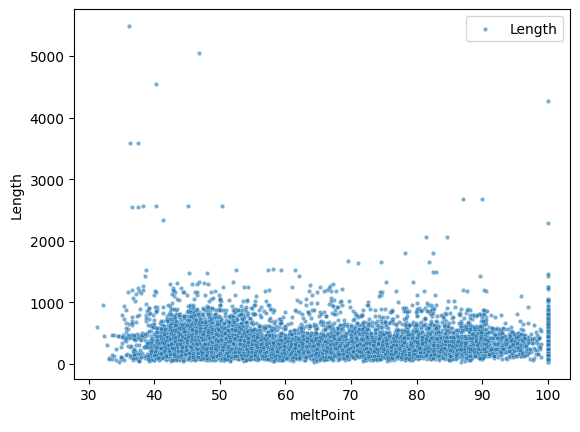

In [30]:
prokaryotes_noNaN = prokaryotes
prokaryotes_noNaN['meltPoint'] = prokaryotes_noNaN['meltPoint'].fillna(100)
sns.scatterplot(data = prokaryotes_noNaN, x = 'meltPoint', y = 'Length', label = 'Length', s= 10, alpha = 0.6)
print(prokaryotes_lysate['meltPoint'].corr(prokaryotes_noNaN['Length']))